In [613]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from datetime import datetime
from tqdm import tqdm

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
import os
import pandas as pd
import glob
import joblib
import numpy as np
import seaborn as sns
import scipy.stats as scs
import matplotlib.pyplot as plt
import copy
import hashlib
import yaml
import json

## 1. IMPORT PARAMS

In [397]:
params_dir = "/Users/avntrr/Documents/Pacmann/params.yml"

In [398]:
def load_params(param_dir):
    with open(param_dir, 'r') as file:
        params = yaml.safe_load(file)
        
    return params

In [399]:
params = load_params(params_dir)

In [400]:
params

{'dataset_dir': '/Users/avntrr/Documents/Pacmann/raw/',
 'datetime_columns': ['tanggal'],
 'int32_columns': ['pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'max'],
 'label': 'categori',
 'label_categories': ['BAIK', 'SEDANG', 'TIDAK SEHAT'],
 'label_categories_new': ['BAIK', 'TIDAK SEHAT'],
 'missing_value_co': 11,
 'missing_value_no2': 18,
 'missing_value_o3': 29,
 'missing_value_pm10': {'BAIK': 28, 'TIDAK SEHAT': 55},
 'missing_value_pm25': {'BAIK': 38, 'TIDAK SEHAT': 82},
 'missing_value_so2': 35,
 'object_columns': ['stasiun', 'critical', 'categori'],
 'predictors': ['stasiun', 'pm10', 'pm25', 'so2', 'co', 'o3', 'no2'],
 'range_co': [-1, 100],
 'range_no2': [-1, 100],
 'range_o3': [-1, 160],
 'range_pm10': [-1, 800],
 'range_pm25': [-1, 400],
 'range_so2': [-1, 500],
 'range_stasiun': ['DKI1 (Bunderan HI)',
  'DKI2 (Kelapa Gading)',
  'DKI3 (Jagakarsa)',
  'DKI4 (Lubang Buaya)',
  'DKI5 (Kebon Jeruk) Jakarta Barat']}

2. DATA COLLECTION

In [401]:
csv_files = glob.glob('*.{}'.format('csv'))
csv_files

['agustus_2021.csv',
 'oktober_2021.csv',
 'september_2021.csv',
 'november_2021.csv',
 'desember_2021.csv']

In [402]:
dataset = pd.DataFrame()
# append all files together
for file in csv_files:
            df_temp = pd.read_csv(file)
            dataset = dataset.append(df_temp, ignore_index=True)
dataset

/var/folders/d1/6qk1n6ts36zb0kb689t4gg0r0000gn/T/ipykernel_63475/2785968420.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(df_temp, ignore_index=True)
/var/folders/d1/6qk1n6ts36zb0kb689t4gg0r0000gn/T/ipykernel_63475/2785968420.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(df_temp, ignore_index=True)
/var/folders/d1/6qk1n6ts36zb0kb689t4gg0r0000gn/T/ipykernel_63475/2785968420.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(df_temp, ignore_index=True)
/var/folders/d1/6qk1n6ts36zb0kb689t4gg0r0000gn/T/ipykernel_63475/2785968420.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

,tanggal,stasiun,pm10,pm25,so2,co,o3,no2,max,critical,categori
0,2021-08-01,DKI1 (Bunderan HI),51,68,25,8,29,22,68,PM25,SEDANG
1,2021-08-02,DKI1 (Bunderan HI),47,63,24,10,25,28,63,PM25,SEDANG
2,2021-08-03,DKI1 (Bunderan HI),50,68,26,11,19,35,68,PM25,SEDANG
3,2021-08-04,DKI1 (Bunderan HI),52,70,29,8,24,26,70,PM25,SEDANG
4,2021-08-05,DKI1 (Bunderan HI),52,66,29,9,21,27,66,PM25,SEDANG
...,...,...,...,...,...,...,...,...,...,...,...
760,2021-12-27,DKI5 (Kebon Jeruk) Jakarta Barat,54,76,36,14,21,47,76,PM25,SEDANG
761,2021-12-28,DKI5 (Kebon Jeruk) Jakarta Barat,44,68,20,11,21,33,68,PM25,SEDANG
762,2021-12-29,DKI5 (Kebon Jeruk) Jakarta Barat,34,54,28,8,25,29,54,PM25,SEDANG
763,2021-12-30,DKI5 (Kebon Jeruk) Jakarta Barat,53,75,25,15,23,44,75,PM25,SEDANG


2.1. GANTI "SEDANG" MENJADI "BAIK"

In [403]:
dataset['categori'] = dataset['categori'].replace(['SEDANG'], 'BAIK')
dataset

,tanggal,stasiun,pm10,pm25,so2,co,o3,no2,max,critical,categori
0,2021-08-01,DKI1 (Bunderan HI),51,68,25,8,29,22,68,PM25,BAIK
1,2021-08-02,DKI1 (Bunderan HI),47,63,24,10,25,28,63,PM25,BAIK
2,2021-08-03,DKI1 (Bunderan HI),50,68,26,11,19,35,68,PM25,BAIK
3,2021-08-04,DKI1 (Bunderan HI),52,70,29,8,24,26,70,PM25,BAIK
4,2021-08-05,DKI1 (Bunderan HI),52,66,29,9,21,27,66,PM25,BAIK
...,...,...,...,...,...,...,...,...,...,...,...
760,2021-12-27,DKI5 (Kebon Jeruk) Jakarta Barat,54,76,36,14,21,47,76,PM25,BAIK
761,2021-12-28,DKI5 (Kebon Jeruk) Jakarta Barat,44,68,20,11,21,33,68,PM25,BAIK
762,2021-12-29,DKI5 (Kebon Jeruk) Jakarta Barat,34,54,28,8,25,29,54,PM25,BAIK
763,2021-12-30,DKI5 (Kebon Jeruk) Jakarta Barat,53,75,25,15,23,44,75,PM25,BAIK


In [404]:
joblib.dump(dataset, "/Users/avntrr/Documents/Pacmann/dataset.pkl")

['/Users/avntrr/Documents/Pacmann/dataset.pkl']

## 2. DATA DEFINITION

tanggal         :
    [datetime]
    [00:00 01/08/2021 - 23:59 31/12/2021]
    waktu saat pengambilan sampel

stasiun         :
    [object]
    ['DKI1 (Bunderan HI)', 'DKI2 (Kelapa Gading)', 'DKI3 (Jagakarsa)', 'DKI4 (Lubang Buaya)', 'DKI5 (Kebon Jeruk) Jakarta Barat']
    lokasi saat pengambilan sampel

pm10            :
    [integer]
    [0 - 800]
    partikel udara yang berukuran lebih kecil dari 10 mikron

pm25            :
    [integer]
    [0 - 400]
    partikel udara yang berukuran lebih kecil dari 2.5 mikron

so2             :
    [integer]
    [0 - 500]
    sulfur dioksida

co              :
    [integer]
    [0 - 100]
    karbon monoksida

o3              :
    [integer]
    [0 - 140]
    ozone

no2             :
    [integer]
    [0 - 100]
    nitrogen dioksida

max             :
    [integer]
    [0 - 800]
    nilai paling besar diantara pm10, pm25, so2, co, o3, dan no2

critical        :
    [object]
    [PM10, PM25, SO2, CO, O3, dan NO2]
    nama kolom untuk nilai max

categori        :
    [object]
    [BAIK, TIDAK SEHAT]
    kategori untuk data pengukuran udara

location        : tidak termasuk karena ada data yang nama kolomnya tidak standar

## 3. DATA VALIDATION

3.1. Tipe Data

In [405]:
dataset.dtypes

tanggal     object
stasiun     object
pm10        object
pm25        object
so2         object
co          object
o3          object
no2         object
max         object
critical    object
categori    object
dtype: object

3.2. Range 

In [406]:
dataset.describe()

,tanggal,stasiun,pm10,pm25,so2,co,o3,no2,max,critical,categori
count,765,765,765,765,765,765,765,765,765,757,764
unique,153,5,107,164,103,41,105,83,163,5,3
top,2021-08-01,DKI1 (Bunderan HI),---,71,---,10,---,15,77,PM25,BAIK
freq,5,153,32,21,95,65,32,42,20,714,670


3.3. Dimensi Data

In [407]:
dataset.shape

(765, 11)

3.4. Handling Columns Error

In [408]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765 entries, 0 to 764
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tanggal   765 non-null    object
 1   stasiun   765 non-null    object
 2   pm10      765 non-null    object
 3   pm25      765 non-null    object
 4   so2       765 non-null    object
 5   co        765 non-null    object
 6   o3        765 non-null    object
 7   no2       765 non-null    object
 8   max       765 non-null    object
 9   critical  757 non-null    object
 10  categori  764 non-null    object
dtypes: object(11)
memory usage: 65.9+ KB


3.5.1. Handling Column "Tanggal"

In [409]:
#HANDLING COLUMN TANGGAL
dataset.tanggal = pd.to_datetime(dataset.tanggal)

3.5.2. Handling Column "PM10"

In [410]:
#HANDLING PM10
dataset.pm10 = dataset.pm10.astype(int)

ValueError: invalid literal for int() with base 10: '---'

In [411]:
#Ganti "---" dengan suatu numerik
dataset.pm10 = dataset.pm10.replace("---", -1).astype(int)

In [412]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765 entries, 0 to 764
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   tanggal   765 non-null    datetime64[ns]
 1   stasiun   765 non-null    object        
 2   pm10      765 non-null    int64         
 3   pm25      765 non-null    object        
 4   so2       765 non-null    object        
 5   co        765 non-null    object        
 6   o3        765 non-null    object        
 7   no2       765 non-null    object        
 8   max       765 non-null    object        
 9   critical  757 non-null    object        
 10  categori  764 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 65.9+ KB


3.5.3. Handling Column "PM25"

In [413]:
dataset.pm25 = dataset.pm25.astype(int)

ValueError: invalid literal for int() with base 10: '---'

In [414]:
#Ganti "---" dengan suatu numerik
dataset.pm25.fillna(-1, inplace = True)

In [415]:
dataset.pm25 = dataset.pm25.replace("---", -1).astype(int)

In [416]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765 entries, 0 to 764
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   tanggal   765 non-null    datetime64[ns]
 1   stasiun   765 non-null    object        
 2   pm10      765 non-null    int64         
 3   pm25      765 non-null    int64         
 4   so2       765 non-null    object        
 5   co        765 non-null    object        
 6   o3        765 non-null    object        
 7   no2       765 non-null    object        
 8   max       765 non-null    object        
 9   critical  757 non-null    object        
 10  categori  764 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 65.9+ KB


3.5.4. Handling Column "SO2"

In [417]:
dataset.so2 = dataset.so2.astype(int)

ValueError: invalid literal for int() with base 10: '---'

In [418]:
#Ganti "---" dengan suatu numerik
dataset.so2 = dataset.so2.replace("---", -1).astype(int)

In [419]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765 entries, 0 to 764
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   tanggal   765 non-null    datetime64[ns]
 1   stasiun   765 non-null    object        
 2   pm10      765 non-null    int64         
 3   pm25      765 non-null    int64         
 4   so2       765 non-null    int64         
 5   co        765 non-null    object        
 6   o3        765 non-null    object        
 7   no2       765 non-null    object        
 8   max       765 non-null    object        
 9   critical  757 non-null    object        
 10  categori  764 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 65.9+ KB


3.5.5. Handling Column "CO"

In [420]:
dataset.co = dataset.co.astype(int)

ValueError: invalid literal for int() with base 10: '---'

In [421]:
#Ganti "---" dengan suatu numerik
dataset.co = dataset.co.replace("---", -1).astype(int)

In [422]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765 entries, 0 to 764
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   tanggal   765 non-null    datetime64[ns]
 1   stasiun   765 non-null    object        
 2   pm10      765 non-null    int64         
 3   pm25      765 non-null    int64         
 4   so2       765 non-null    int64         
 5   co        765 non-null    int64         
 6   o3        765 non-null    object        
 7   no2       765 non-null    object        
 8   max       765 non-null    object        
 9   critical  757 non-null    object        
 10  categori  764 non-null    object        
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 65.9+ KB


3.5.6. Handling Column "O3"

In [423]:
dataset.o3 = dataset.o3.astype(int)

ValueError: invalid literal for int() with base 10: '---'

In [424]:
#Ganti "---" dengan suatu numerik
dataset.o3 = dataset.o3.replace("---", -1).astype(int)

In [425]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765 entries, 0 to 764
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   tanggal   765 non-null    datetime64[ns]
 1   stasiun   765 non-null    object        
 2   pm10      765 non-null    int64         
 3   pm25      765 non-null    int64         
 4   so2       765 non-null    int64         
 5   co        765 non-null    int64         
 6   o3        765 non-null    int64         
 7   no2       765 non-null    object        
 8   max       765 non-null    object        
 9   critical  757 non-null    object        
 10  categori  764 non-null    object        
dtypes: datetime64[ns](1), int64(5), object(5)
memory usage: 65.9+ KB


3.5.7. Handling Column "NO2"

In [426]:
dataset.no2 = dataset.no2.astype(int)

ValueError: invalid literal for int() with base 10: '---'

In [427]:
#Ganti "---" dengan suatu numerik
dataset.no2 = dataset.no2.replace("---", -1).astype(int)

3.5.8. Handling Column "Max"

In [428]:
dataset["max"] = dataset["max"].astype(int)

ValueError: invalid literal for int() with base 10: 'PM25'

In [429]:
#cek data yang salah input
dataset[dataset["max"] == "PM25"]

,tanggal,stasiun,pm10,pm25,so2,co,o3,no2,max,critical,categori
612,2021-12-03,DKI1 (Bunderan HI),49,31,9,19,7,49,PM25,BAIK,NaN


In [430]:
# quick fix the problem
dataset.loc[612, "max"] = 49
dataset.loc[612, "critical"] = "PM10"
dataset.loc[612, "categori"] = "BAIK"

In [431]:
dataset[dataset["max"] == "PM25"]

,tanggal,stasiun,pm10,pm25,so2,co,o3,no2,max,critical,categori


In [432]:
dataset.loc[612]

tanggal     2021-12-03 00:00:00
stasiun      DKI1 (Bunderan HI)
pm10                         49
pm25                         31
so2                           9
co                           19
o3                            7
no2                          49
max                          49
critical                   PM10
categori                   BAIK
Name: 612, dtype: object

In [433]:
dataset["max"] = dataset["max"].astype(int)

3.5.9. Handling Column "Categori" 

In [434]:
dataset.categori.value_counts()

BAIK              671
TIDAK SEHAT        86
TIDAK ADA DATA      8
Name: categori, dtype: int64

In [435]:
dataset.drop(index = dataset[dataset.categori == "TIDAK ADA DATA"].index, inplace = True)

In [436]:
dataset.categori.value_counts()

BAIK           671
TIDAK SEHAT     86
Name: categori, dtype: int64

In [437]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 757 entries, 0 to 764
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   tanggal   757 non-null    datetime64[ns]
 1   stasiun   757 non-null    object        
 2   pm10      757 non-null    int64         
 3   pm25      757 non-null    int64         
 4   so2       757 non-null    int64         
 5   co        757 non-null    int64         
 6   o3        757 non-null    int64         
 7   no2       757 non-null    int64         
 8   max       757 non-null    int64         
 9   critical  757 non-null    object        
 10  categori  757 non-null    object        
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 71.0+ KB


In [438]:
dataset.categori.value_counts()

BAIK           671
TIDAK SEHAT     86
Name: categori, dtype: int64

In [439]:
joblib.dump(dataset, "/Users/avntrr/Documents/Pacmann/dataset_clean.pkl")

['/Users/avntrr/Documents/Pacmann/dataset_clean.pkl']

## 4. DATA DEFENSE

In [440]:
def check_data(input_data, params):
    # check data types
    assert input_data.select_dtypes("datetime").columns.to_list() == params["datetime_columns"], "an error occurs in datetime column(s)."
    assert input_data.select_dtypes("object").columns.to_list() == params["object_columns"], "an error occurs in object column(s)."
    assert input_data.select_dtypes("int").columns.to_list() == params["int32_columns"], "an error occurs in int32 column(s)."

    # check range of data
    assert set(input_data.stasiun).issubset(set(params["range_stasiun"])), "an error occurs in stasiun range."
    assert input_data.pm10.between(params["range_pm10"][0], params["range_pm10"][1]).sum() == len(input_data), "an error occurs in pm10 range."
    assert input_data.pm25.between(params["range_pm25"][0], params["range_pm25"][1]).sum() == len(input_data), "an error occurs in pm25 range."
    assert input_data.so2.between(params["range_so2"][0], params["range_so2"][1]).sum() == len(input_data), "an error occurs in so2 range."
    assert input_data.co.between(params["range_co"][0], params["range_co"][1]).sum() == len(input_data), "an error occurs in co range."
    assert input_data.o3.between(params["range_o3"][0], params["range_o3"][1]).sum() == len(input_data), "an error occurs in o3 range."
    assert input_data.no2.between(params["range_no2"][0], params["range_no2"][1]).sum() == len(input_data), "an error occurs in no2 range."

In [441]:
# jika tidak ada error berarti data sudah sesuai dengan desain kita
check_data(dataset, params)

## 5. DATA SPLITTING

In [442]:
x = dataset[params["predictors"]].copy()
y = dataset.categori.copy()

In [443]:
x = dataset[params["predictors"]].copy()
y = dataset.categori.copy()

In [444]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 757 entries, 0 to 764
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   stasiun  757 non-null    object
 1   pm10     757 non-null    int64 
 2   pm25     757 non-null    int64 
 3   so2      757 non-null    int64 
 4   co       757 non-null    int64 
 5   o3       757 non-null    int64 
 6   no2      757 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 47.3+ KB


In [445]:
y.value_counts()

BAIK           671
TIDAK SEHAT     86
Name: categori, dtype: int64

In [446]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42, stratify = y)

In [447]:
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 42, stratify = y_test)

In [448]:
joblib.dump(x_train, "/Users/avntrr/Documents/Pacmann/x_train.pkl")
joblib.dump(y_train, "/Users/avntrr/Documents/Pacmann/y_train.pkl")
joblib.dump(x_valid, "/Users/avntrr/Documents/Pacmann/x_valid.pkl")
joblib.dump(y_valid, "/Users/avntrr/Documents/Pacmann/y_valid.pkl")
joblib.dump(x_test, "/Users/avntrr/Documents/Pacmann/x_test.pkl")
joblib.dump(y_test, "/Users/avntrr/Documents/Pacmann/y_test.pkl")

['/Users/avntrr/Documents/Pacmann/y_test.pkl']

In [449]:
dataset = pd.concat([x_train, y_train], axis = 1)

## 6. EDA

6.1. Cek Missing Value

In [450]:
dataset.replace(-1, np.nan, inplace = True)

In [451]:
dataset.isnull().sum()

stasiun      0
pm10        18
pm25         8
so2         57
co           2
o3          19
no2          4
categori     0
dtype: int64

6.2. Cek Informasi Statistik

6.2.1. Cek Skewness

In [452]:
dataset.skew(numeric_only = True)

pm10   -0.583481
pm25    0.030411
so2    -0.096708
co      1.545073
o3      0.875801
no2     1.160850
dtype: float64

6.2.2. Pemisahan Data Berdasarkan Kelas

In [453]:
dataset_baik = dataset[dataset.categori == "BAIK"].copy()
dataset_tidak_sehat = dataset[dataset.categori != "BAIK"].copy()

In [454]:
#Kelas 1
dataset_baik.describe()

,pm10,pm25,so2,co,o3,no2
count,459.000000,461.000000,415.000000,467.000000,452.000000,465.000000
mean,50.830065,73.132321,38.274699,10.813704,31.079646,20.266667
std,11.796190,16.452760,13.397913,4.304602,12.721399,10.169992
min,15.000000,26.000000,3.000000,2.000000,7.000000,5.000000
25%,45.000000,63.000000,29.000000,8.000000,22.000000,13.000000
50%,53.000000,75.000000,39.000000,10.000000,29.000000,17.000000
75%,58.500000,85.000000,49.000000,13.000000,37.250000,26.000000
max,87.000000,100.000000,81.000000,44.000000,78.000000,65.000000


In [455]:
#Kelas 0
dataset_tidak_sehat.describe()

,pm10,pm25,so2,co,o3,no2
count,52.000000,60.000000,57.000000,60.000000,58.000000,60.000000
mean,67.057692,110.933333,43.280702,12.500000,33.258621,22.850000
std,7.609111,10.254171,9.238418,3.367341,11.019218,5.873886
min,55.000000,101.000000,17.000000,8.000000,13.000000,12.000000
25%,62.000000,104.000000,39.000000,10.000000,26.000000,18.750000
50%,66.000000,107.500000,42.000000,12.000000,32.000000,22.000000
75%,71.250000,115.250000,45.000000,14.000000,39.000000,25.000000
max,100.000000,157.000000,82.000000,23.000000,70.000000,41.000000


6.2.3. Visualisasi untuk Fitur PM10

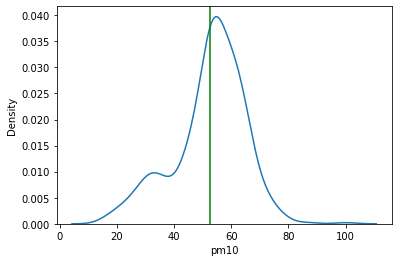

In [456]:
# distribusi pm10 tanpa melihat categori
sns.kdeplot(data = dataset, x = "pm10")
plt.axvline(dataset.pm10.mean(), 0, 1, color = "g")

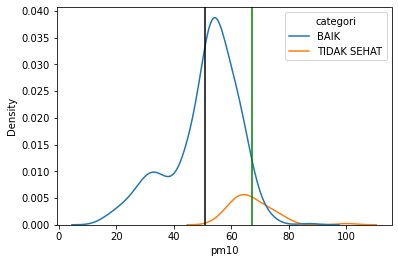

In [457]:
# distribusi pm10 berdasarkan categori

sns.kdeplot(data = dataset, x = "pm10", hue = "categori")
plt.axvline(dataset_tidak_sehat.pm10.mean(), 0, 1, color = "g")
plt.axvline(dataset_baik.pm10.mean(), 0, 1, color = "k")

In [458]:
# distribusi sedikit skew ke kanan namun tidak signifikan, imputasi mean
# mean 2 kelas berbeda jauh, imputasi berdasarkan kelas
# kesimpulan: untuk pm10 akan menggunakan mean dari perkelas untuk imputasi

6.2.4. Visualisasi untuk Fitur PM25

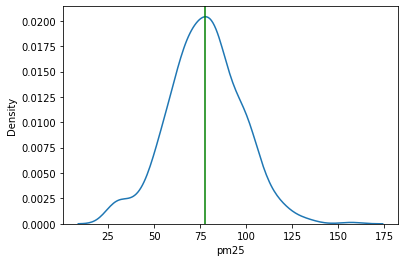

In [459]:
sns.kdeplot(data = dataset, x = "pm25")
plt.axvline(dataset.pm25.mean(), 0, 1, color = "g")

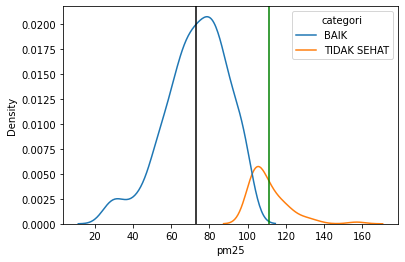

In [460]:
sns.kdeplot(data = dataset, x = "pm25", hue = "categori")
plt.axvline(dataset_tidak_sehat.pm25.mean(), 0, 1, color = "g")
plt.axvline(dataset_baik.pm25.mean(), 0, 1, color = "k")

In [461]:
# distribusi sangat dekat dengan normal (nilai skew fisher-pearson mendekati nol), imputasi mean
# mean 2 kelas berbeda jauh, imputasi berdasarkan kelas
# kesimpulan: untuk pm25 akan menggunakan mean dari perkelas untuk imputasi

6.2.5. Visualisasi untuk Fitur SO25

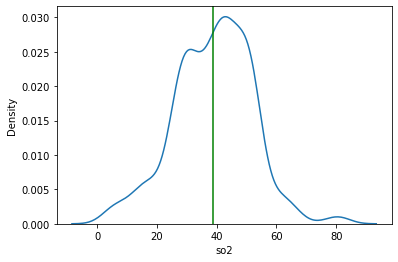

In [462]:
sns.kdeplot(data = dataset, x = "so2")
plt.axvline(dataset.so2.mean(), 0, 1, color = "g")

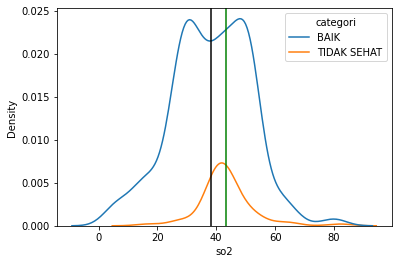

In [463]:
sns.kdeplot(data = dataset, x = "so2", hue = "categori")
plt.axvline(dataset_tidak_sehat.so2.mean(), 0, 1, color = "g")
plt.axvline(dataset_baik.so2.mean(), 0, 1, color = "k")

6.2.6. Visualisasi untuk Fitur CO

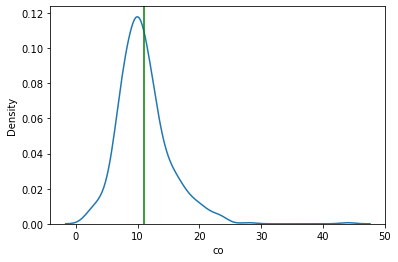

In [464]:
sns.kdeplot(data = dataset, x = "co")
plt.axvline(dataset.co.mean(), 0, 1, color = "g")

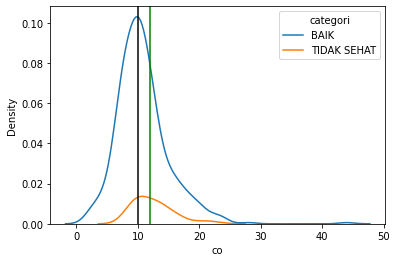

In [465]:
sns.kdeplot(data = dataset, x = "co", hue = "categori")
plt.axvline(dataset_tidak_sehat.co.median(), 0, 1, color = "g")
plt.axvline(dataset_baik.co.median(), 0, 1, color = "k")

6.2.7. Visualisasi untuk Fitur O3

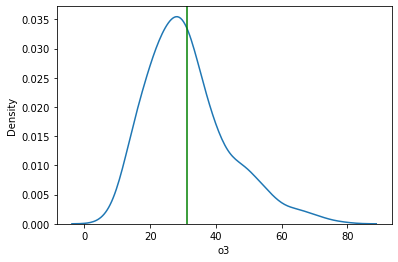

In [466]:
sns.kdeplot(data = dataset, x = "o3")
plt.axvline(dataset.o3.mean(), 0, 1, color = "g")

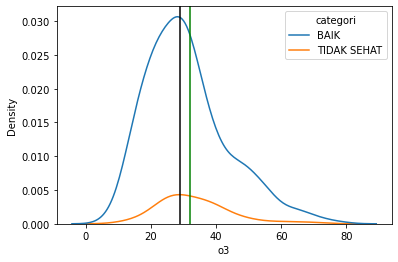

In [467]:
sns.kdeplot(data = dataset, x = "o3", hue = "categori")
plt.axvline(dataset_tidak_sehat.o3.median(), 0, 1, color = "g")
plt.axvline(dataset_baik.o3.median(), 0, 1, color = "k")

6.2.8. Visualisasi untuk Fitur NO2

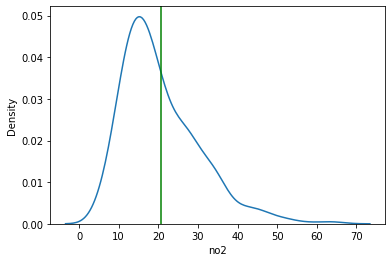

In [468]:
sns.kdeplot(data = dataset, x = "no2")
plt.axvline(dataset.no2.mean(), 0, 1, color = "g")

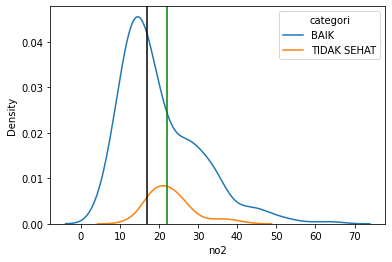

In [469]:
sns.kdeplot(data = dataset, x = "no2", hue = "categori")
plt.axvline(dataset_tidak_sehat.no2.median(), 0, 1, color = "g")
plt.axvline(dataset_baik.no2.median(), 0, 1, color = "k")

6.2.9. Pearson Correlation

<AxesSubplot: >

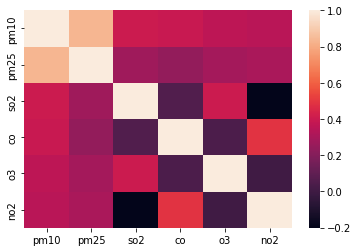

In [470]:
sns.heatmap(dataset.corr())

6.2.10. T Test untuk PM10

In [471]:
# h0    = mean pm10 untuk kelas 0 = mean pm10 untuk kelas 1
# h1    = mean pm10 untuk kelas 0 != mean pm10 untuk kelas 1

In [472]:
# perform t-test untuk 2 variabel
scs.ttest_ind(
    dataset_baik[dataset_baik.pm10.isnull() != True].pm10,
    dataset_tidak_baik[dataset_tidak_sehat.pm10.isnull() != True].pm10
)

Ttest_indResult(statistic=-9.689515085773392, pvalue=1.727350498362646e-20)

In [473]:
# nilai t critical untuk alpha 0.05
scs.t.ppf(0.05, df = (len(dataset) - 2))

-1.647750149859035

6.2.11. T Test untuk PM25

In [474]:
# perform t-test untuk 2 variabel
scs.ttest_ind(
    dataset_baik[dataset_baik.pm25.isnull() != True].pm25,
    dataset_tidak_baik[dataset_tidak_sehat.pm25.isnull() != True].pm25
)

Ttest_indResult(statistic=-17.354771270048253, pvalue=1.5333725489334524e-53)

In [475]:
# nilai t critical untuk alpha 0.05
scs.t.ppf(0.05, df = (len(dataset) - 2))

-1.647750149859035

6.2.12. T Test untuk SO2

In [476]:
# perform t-test untuk 2 variabel
scs.ttest_ind(
    dataset_baik[dataset_baik.so2.isnull() != True].so2,
    dataset_tidak_baik[dataset_tidak_sehat.so2.isnull() != True].so2
)

Ttest_indResult(statistic=-2.7318585448100086, pvalue=0.00653488648090878)

In [477]:
# nilai t critical untuk alpha 0.05
scs.t.ppf(0.05, df = (len(dataset) - 2))

-1.647750149859035

6.2.13. T Test untuk CO

In [478]:
# perform t-test untuk 2 variabel
scs.ttest_ind(
    dataset_baik[dataset_baik.co.isnull() != True].co,
    dataset_tidak_baik[dataset_tidak_sehat.co.isnull() != True].co
)

Ttest_indResult(statistic=-2.920869060226972, pvalue=0.003640707328131908)

In [479]:
# nilai t critical untuk alpha 0.05
scs.t.ppf(0.05, df = (len(dataset) - 2))

-1.647750149859035

6.2.14. T Test untuk O3

In [480]:
# perform t-test untuk 2 variabel
scs.ttest_ind(
    dataset_baik[dataset_baik.o3.isnull() != True].o3,
    dataset_tidak_baik[dataset_tidak_sehat.o3.isnull() != True].o3,
    equal_var = False
)

Ttest_indResult(statistic=-1.3916577640410066, pvalue=0.16798841142750007)

In [481]:
# nilai t critical untuk alpha 0.05
scs.t.ppf(0.05, df = (len(dataset) - 2))

-1.647750149859035

6.2.15. T Test untuk NO2

In [482]:
# perform t-test untuk 2 variabel
scs.ttest_ind(
    dataset_baik[dataset_baik.no2.isnull() != True].no2,
    dataset_tidak_baik[dataset_tidak_sehat.no2.isnull() != True].no2
)

Ttest_indResult(statistic=-1.9255434400964688, pvalue=0.054703254945911294)

In [483]:
# nilai t critical untuk alpha 0.05
scs.t.ppf(0.05, df = (len(dataset) - 2))

-1.647750149859035

6.3. Cek Imbalance

In [484]:
dataset.categori.value_counts()

BAIK           469
TIDAK SEHAT     60
Name: categori, dtype: int64

<AxesSubplot: xlabel='categori', ylabel='Count'>

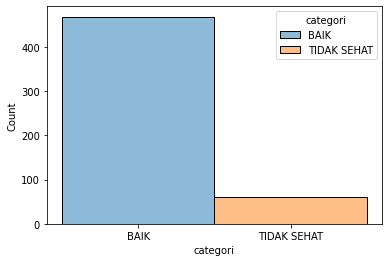

In [485]:
sns.histplot(data = dataset, x = "categori", hue = "categori")

6.4. Cek Outliers

<AxesSubplot: xlabel='pm10'>

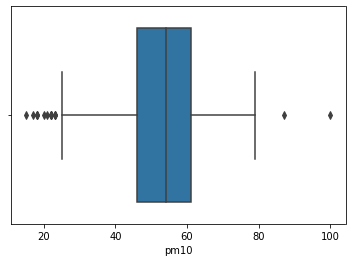

In [486]:
sns.boxplot(data = dataset, x = "pm10")

<AxesSubplot: xlabel='pm25'>

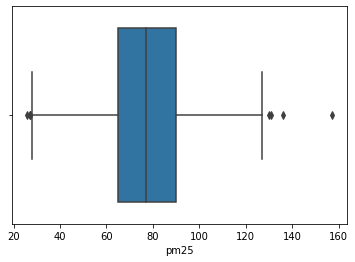

In [487]:
sns.boxplot(data = dataset, x = "pm25")

<AxesSubplot: xlabel='so2'>

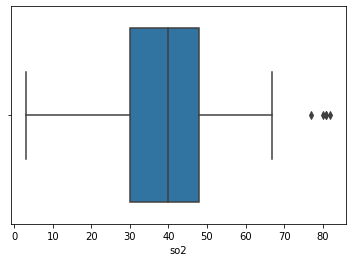

In [488]:
sns.boxplot(data = dataset, x = "so2")

<AxesSubplot: xlabel='co'>

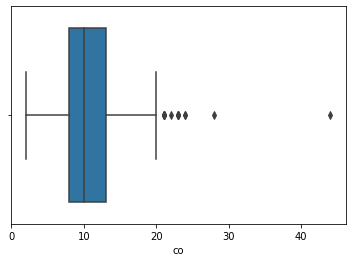

In [489]:
sns.boxplot(data = dataset, x = "co")

<AxesSubplot: xlabel='o3'>

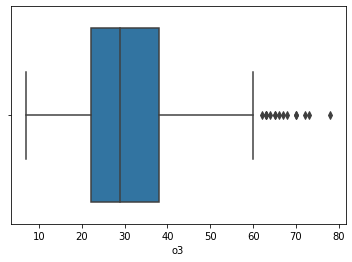

In [490]:
sns.boxplot(data = dataset, x = "o3")

<AxesSubplot: xlabel='no2'>

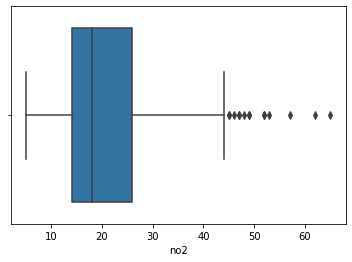

In [491]:
sns.boxplot(data = dataset, x = "no2")

## 7. KESIMPULAN

1. Missing value handling
1.1. pm10      : mean kelas
1.2. pm25      : mean kelas
1.3. so2       : mean
1.4. co        : median
1.5. o3        : median
1.6. no2       : median

2. Join kategori sedang dan tidak sehat menjadi tidak baik

3. Balancing label baik dan tidak baik

4. Outlier removal

## 8. JOIN CATEGORIES

In [492]:
params_dir = "/Users/avntrr/Documents/Pacmann/params.yml"

In [493]:
def load_params(param_dir):
    with open(param_dir, "r") as file:
        params = yaml.safe_load(file)
        
    return params

In [494]:
def params_updater(key, value, params, params_dir):
    params = params.copy()
    params[key] = value

    with open(params_dir, "w") as file:
        yaml.dump(params, file)
    
    params = load_params(params_dir)

    return params

In [495]:
params = load_params(params_dir)

In [496]:
dataset = pd.concat([x_train, y_train], axis = 1)

valid_set = pd.concat([x_valid, y_valid], axis = 1)

test_set = pd.concat([x_test, y_test], axis = 1)

In [497]:
def join_cat(set_data, params):
    if params["label"] in set_data.columns.to_list():
        set_data = set_data.copy()
        set_data.categori.replace(params["label_categories"][1], params["label_categories"][2], inplace = True)
        set_data.categori.replace(params["label_categories"][2], params["label_categories_new"][1], inplace = True)
        return set_data
    else:
        raise RuntimeError("Kolom label tidak terdeteksi pada set data yang diberikan!")

In [498]:
params = params_updater("label", "categori", params, params_dir)
params = params_updater("label_categories", ["BAIK", "SEDANG", "TIDAK SEHAT"], params, params_dir)
params = params_updater("label_categories_new", ["BAIK", "TIDAK SEHAT"], params, params_dir)

8.1. Train Set

In [499]:
dataset.categori.value_counts()

BAIK           469
TIDAK SEHAT     60
Name: categori, dtype: int64

In [500]:
dataset = join_cat(dataset, params)

In [501]:
dataset.categori.value_counts()

BAIK           469
TIDAK SEHAT     60
Name: categori, dtype: int64

8.2. Valid Set

In [502]:
valid_set.categori.value_counts()

BAIK           101
TIDAK SEHAT     13
Name: categori, dtype: int64

In [503]:
valid_set = join_cat(valid_set, params)

In [504]:
valid_set.categori.value_counts()

BAIK           101
TIDAK SEHAT     13
Name: categori, dtype: int64

8.3. Test Set

In [505]:
test_set.categori.value_counts()

BAIK           101
TIDAK SEHAT     13
Name: categori, dtype: int64

In [506]:
test_set = join_cat(test_set, params)

In [507]:
test_set.categori.value_counts()

BAIK           101
TIDAK SEHAT     13
Name: categori, dtype: int64

## 9. HANDLING MISSING VALUE

In [508]:
def nan_detector(set_data):
    set_data = set_data.copy()
    set_data.replace(-1, np.nan, inplace = True)
    return set_data

9.1. Convert -1 to NaN

9.1.1. Trainset

In [509]:
dataset.describe()

,pm10,pm25,so2,co,o3,no2
count,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000
mean,50.661626,76.298677,34.582231,10.960302,30.166352,20.398866
std,15.613492,21.981346,17.474693,4.295471,13.713475,9.945575
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,45.000000,64.000000,27.000000,8.000000,22.000000,13.000000
50%,54.000000,77.000000,38.000000,10.000000,29.000000,18.000000
75%,61.000000,90.000000,47.000000,13.000000,37.000000,26.000000
max,100.000000,157.000000,82.000000,44.000000,78.000000,65.000000


In [510]:
dataset.isnull().sum()

stasiun     0
pm10        0
pm25        0
so2         0
co          0
o3          0
no2         0
categori    0
dtype: int64

In [511]:
dataset = nan_detector(dataset)

In [512]:
dataset.isnull().sum()

stasiun      0
pm10        18
pm25         8
so2         57
co           2
o3          19
no2          4
categori     0
dtype: int64

9.1.2. Validset

In [513]:
valid_set.describe()

,pm10,pm25,so2,co,o3,no2
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,47.175439,73.192982,32.307018,10.394737,29.649123,18.982456
std,15.584338,22.843398,17.220140,3.905110,10.772780,8.296478
min,-1.000000,-1.000000,-1.000000,3.000000,11.000000,4.000000
25%,38.250000,59.250000,26.000000,8.000000,22.000000,13.250000
50%,50.000000,75.000000,38.000000,9.500000,28.500000,17.000000
75%,58.000000,86.000000,44.000000,14.000000,36.000000,24.000000
max,76.000000,140.000000,62.000000,19.000000,59.000000,49.000000


In [514]:
valid_set.isnull().sum()

stasiun     0
pm10        0
pm25        0
so2         0
co          0
o3          0
no2         0
categori    0
dtype: int64

In [515]:
valid_set = nan_detector(valid_set)

In [516]:
valid_set.isnull().sum()

stasiun      0
pm10         4
pm25         2
so2         16
co           0
o3           0
no2          0
categori     0
dtype: int64

9.1.3. Testset

In [517]:
test_set.describe()

,pm10,pm25,so2,co,o3,no2
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,52.938596,74.938596,35.877193,11.236842,28.921053,20.342105
std,18.943458,23.614637,18.114748,4.396907,13.670034,8.930240
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,47.250000,63.000000,29.000000,9.000000,20.000000,14.250000
50%,53.500000,77.000000,39.000000,11.000000,27.000000,19.000000
75%,61.000000,88.000000,48.000000,14.000000,38.000000,26.750000
max,179.000000,134.000000,76.000000,28.000000,64.000000,44.000000


In [518]:
test_set.isnull().sum()

stasiun     0
pm10        0
pm25        0
so2         0
co          0
o3          0
no2         0
categori    0
dtype: int64

In [519]:
test_set = nan_detector(test_set)

In [520]:
test_set.isnull().sum()

stasiun      0
pm10         2
pm25         2
so2         14
co           1
o3           5
no2          1
categori     0
dtype: int64

9.2. Handling in PM10

9.2.1. Trainset

In [521]:
impute_1 = int(dataset[dataset.categori == "BAIK"].pm10.mean())
impute_0 = int(dataset[dataset.categori == "TIDAK SEHAT"].pm10.mean())

In [522]:
impute_1, impute_0

(50, 67)

In [523]:
params = params_updater("missing_value_pm10", {"BAIK": 28, "TIDAK SEHAT": 55}, params, params_dir)

In [524]:
dataset.loc[dataset[(dataset.categori == "BAIK") & (dataset.pm10.isnull() == True)].index, "pm10"] = impute_1
dataset.loc[dataset[(dataset.categori == "TIDAK SEHAT") & (dataset.pm10.isnull() == True)].index, "pm10"] = impute_0

In [525]:
dataset[dataset.categori == "BAIK"].pm10.isnull().sum(), dataset[dataset.categori == "TIDAK SEHAT"].pm10.isnull().sum()

(0, 0)

9.2.2. Validset

In [526]:
valid_set[valid_set.categori == "BAIK"].pm10.isnull().sum(), valid_set[valid_set.categori == "TIDAK SEHAT"].pm10.isnull().sum()

(2, 2)

In [527]:
valid_set.loc[valid_set[(valid_set.categori == "BAIK") & (valid_set.pm10.isnull() == True)].index, "pm10"] = impute_1
valid_set.loc[valid_set[(valid_set.categori == "TIDAK SEHAT") & (valid_set.pm10.isnull() == True)].index, "pm10"] = impute_0

In [528]:
valid_set[valid_set.categori == "BAIK"].pm10.isnull().sum(), valid_set[valid_set.categori == "TIDAK SEHAT"].pm10.isnull().sum()

(0, 0)

9.2.3. Testset

In [529]:
test_set[test_set.categori == "BAIK"].pm10.isnull().sum(), test_set[test_set.categori == "TIDAK SEHAT"].pm10.isnull().sum()

(2, 0)

In [530]:
test_set.loc[test_set[(test_set.categori == "BAIK") & (test_set.pm10.isnull() == True)].index, "pm10"] = impute_1
test_set.loc[test_set[(test_set.categori == "TIDAK SEHAT") & (test_set.pm10.isnull() == True)].index, "pm10"] = impute_0

In [531]:
test_set[test_set.categori == "BAIK"].pm10.isnull().sum(), test_set[test_set.categori == "TIDAK SEHAT"].pm10.isnull().sum()

(0, 0)

9.3. Handling in PM25

9.3.1. Trainset

In [532]:
impute_1 = int(dataset[dataset.categori == "BAIK"].pm25.mean())
impute_0 = int(dataset[dataset.categori == "TIDAK SEHAT"].pm25.mean())

In [533]:
impute_1, impute_0

(73, 110)

In [534]:
params = params_updater("missing_value_pm25", {"BAIK": 38, "TIDAK SEHAT": 82}, params, params_dir)

In [535]:
dataset[dataset.categori == "BAIK"].pm25.isnull().sum(), dataset[dataset.categori == "TIDAK SEHAT"].pm25.isnull().sum()

(8, 0)

In [536]:
dataset.loc[dataset[(dataset.categori == "BAIK") & (dataset.pm25.isnull() == True)].index, "pm25"] = impute_1
dataset.loc[dataset[(dataset.categori == "TIDAK SEHAT") & (dataset.pm25.isnull() == True)].index, "pm25"] = impute_0

In [537]:
dataset[dataset.categori == "BAIK"].pm10.isnull().sum(), dataset[dataset.categori == "TIDAK SEHAT"].pm10.isnull().sum()

(0, 0)

9.3.2. Validset

In [538]:
valid_set[valid_set.categori == "BAIK"].pm25.isnull().sum(), valid_set[valid_set.categori == "TIDAK SEHAT"].pm25.isnull().sum()

(2, 0)

In [539]:
valid_set.loc[valid_set[(valid_set.categori == "BAIK") & (valid_set.pm25.isnull() == True)].index, "pm25"] = impute_1
valid_set.loc[valid_set[(valid_set.categori == "TIDAK SEHAT") & (valid_set.pm25.isnull() == True)].index, "pm25"] = impute_0

In [540]:
dataset[dataset.categori == "BAIK"].pm10.isnull().sum(), dataset[dataset.categori == "TIDAK SEHAT"].pm10.isnull().sum()

(0, 0)

9.3.3. Testset

In [541]:
test_set[test_set.categori == "BAIK"].pm25.isnull().sum(), test_set[test_set.categori == "TIDAK SEHAT"].pm25.isnull().sum()

(2, 0)

In [542]:
test_set.loc[test_set[(test_set.categori == "BAIK") & (test_set.pm25.isnull() == True)].index, "pm25"] = impute_1
test_set.loc[test_set[(test_set.categori == "TIDAK SEHAT") & (test_set.pm25.isnull() == True)].index, "pm25"] = impute_0

In [543]:
test_set[test_set.categori == "BAIK"].pm10.isnull().sum(), test_set[test_set.categori == "TIDAK SEHAT"].pm10.isnull().sum()

(0, 0)

9.4. Handling in SO2, CO, O3, NO2

9.4.1. Trainset

In [544]:
impute_so2 = int(dataset.so2.mean())
impute_co = int(dataset.co.median())
impute_o3 = int(dataset.o3.median())
impute_no2 = int(dataset.no2.median())


In [545]:
impute_values = {"so2" : impute_so2, "co" : impute_co, "o3" : impute_o3, "no2" : impute_no2}

In [546]:
impute_values

{'so2': 38, 'co': 10, 'o3': 29, 'no2': 18}

In [547]:
params = params_updater("missing_value_so2", 35, params, params_dir)
params = params_updater("missing_value_co", 11, params, params_dir)
params = params_updater("missing_value_o3", 29, params, params_dir)
params = params_updater("missing_value_no2", 18, params, params_dir)

In [548]:
dataset.isnull().sum()

stasiun      0
pm10         0
pm25         0
so2         57
co           2
o3          19
no2          4
categori     0
dtype: int64

In [549]:
dataset.fillna(value = impute_values, inplace = True)

In [550]:
dataset.isnull().sum()

stasiun     0
pm10        0
pm25        0
so2         0
co          0
o3          0
no2         0
categori    0
dtype: int64

9.4.2. Validset

In [551]:
valid_set.isnull().sum()

stasiun      0
pm10         0
pm25         0
so2         16
co           0
o3           0
no2          0
categori     0
dtype: int64

In [552]:
valid_set.fillna(value = impute_values, inplace = True)

In [553]:
valid_set.isnull().sum()

stasiun     0
pm10        0
pm25        0
so2         0
co          0
o3          0
no2         0
categori    0
dtype: int64

9.4.3. Testset

In [554]:
test_set.isnull().sum()

stasiun      0
pm10         0
pm25         0
so2         14
co           1
o3           5
no2          1
categori     0
dtype: int64

In [555]:
test_set.fillna(value = impute_values, inplace = True)

In [556]:
test_set.isnull().sum()

stasiun     0
pm10        0
pm25        0
so2         0
co          0
o3          0
no2         0
categori    0
dtype: int64

## 10. ENCODING STASIUN

In [557]:
ohe_statiun = OneHotEncoder(sparse = False)

In [558]:
ohe_statiun.fit(np.array(params["range_stasiun"]).reshape(-1, 1))

OneHotEncoder(sparse=False)

In [559]:
ohe_statiun.categories_

[array(['DKI1 (Bunderan HI)', 'DKI2 (Kelapa Gading)', 'DKI3 (Jagakarsa)',
        'DKI4 (Lubang Buaya)', 'DKI5 (Kebon Jeruk) Jakarta Barat'],
       dtype='<U32')]

In [560]:
joblib.dump(ohe_statiun, "/Users/avntrr/Documents/Pacmann/ohe_stasiun.pkl")

['/Users/avntrr/Documents/Pacmann/ohe_stasiun.pkl']

10.1. Trainset

In [561]:
stasiun_features = ohe_statiun.transform(np.array(dataset.stasiun.to_list()).reshape(-1, 1))

In [562]:
stasiun_features = pd.DataFrame(stasiun_features, columns = params["range_stasiun"])

In [563]:
stasiun_features.set_index(dataset.index, inplace = True)

In [564]:
dataset = pd.concat([stasiun_features, dataset], axis = 1)

In [565]:
dataset.drop(columns = "stasiun", inplace = True)

10.2. Validset

In [566]:
stasiun_features = ohe_statiun.transform(np.array(valid_set.stasiun.to_list()).reshape(-1, 1))

In [567]:
stasiun_features = pd.DataFrame(stasiun_features, columns = params["range_stasiun"])

In [568]:
stasiun_features.set_index(valid_set.index, inplace = True)

In [569]:
valid_set = pd.concat([stasiun_features, valid_set], axis = 1)

In [570]:
valid_set.drop(columns = "stasiun", inplace = True)

10.3. Testset

In [571]:
stasiun_features = ohe_statiun.transform(np.array(test_set.stasiun.to_list()).reshape(-1, 1))

In [572]:
stasiun_features = pd.DataFrame(stasiun_features, columns = params["range_stasiun"])

In [573]:
stasiun_features.set_index(test_set.index, inplace = True)

In [574]:
test_set = pd.concat([stasiun_features, test_set], axis = 1)

In [575]:
test_set.drop(columns = "stasiun", inplace = True)

## 11. BALANCING LABEL

<AxesSubplot: xlabel='categori', ylabel='Count'>

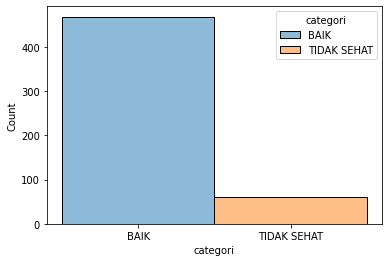

In [576]:
sns.histplot(data = dataset, x = "categori", hue = "categori")

11.1. Undersampling

In [577]:
rus = RandomUnderSampler(random_state = 26)

In [578]:
x_rus, y_rus = rus.fit_resample(dataset.drop("categori", axis = 1), dataset.categori)

In [579]:
dataset_rus = pd.concat([x_rus, y_rus], axis = 1)

<AxesSubplot: xlabel='categori', ylabel='Count'>

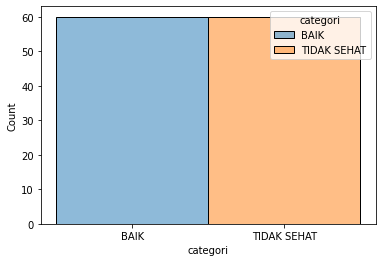

In [580]:
sns.histplot(dataset_rus, x = "categori", hue = "categori")

11.2. Oversampling

In [581]:
ros = RandomOverSampler(random_state = 11)

In [582]:
x_ros, y_ros = ros.fit_resample(dataset.drop("categori", axis = 1), dataset.categori)

In [583]:
dataset_ros = pd.concat([x_ros, y_ros], axis = 1)

<AxesSubplot: xlabel='categori', ylabel='Count'>

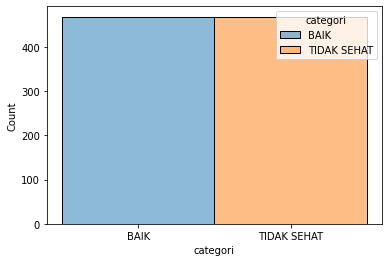

In [584]:
sns.histplot(dataset_ros, x = "categori", hue = "categori")

11.3. SMOTE

In [585]:
sm = SMOTE(random_state = 112)

In [586]:
x_sm, y_sm = sm.fit_resample(dataset.drop("categori", axis = 1), dataset.categori)

In [587]:
dataset_ros = pd.concat([x_ros, y_ros], axis = 1)

<AxesSubplot: xlabel='categori', ylabel='Count'>

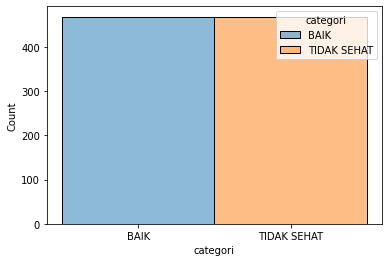

In [588]:
sns.histplot(dataset_ros, x = "categori", hue = "categori")

## 12. LABEL ENCODING

In [589]:
le_categori = LabelEncoder()

In [590]:
le_categori.fit(params["label_categories_new"])

LabelEncoder()

In [591]:
joblib.dump(le_categori, "/Users/avntrr/Documents/Pacmann/le_categori.pkl")

['/Users/avntrr/Documents/Pacmann/le_categori.pkl']

In [592]:
params["label_categories_new"]

['BAIK', 'TIDAK SEHAT']

12.1. Undersampling Set

In [593]:
list(y_rus.unique()) == params["label_categories_new"]

True

In [594]:
y_rus = le_categori.transform(y_rus)

12.2. Oversampling Set

In [595]:
list(y_ros.unique()) == params["label_categories_new"]

True

In [596]:
y_ros = le_categori.transform(y_ros)

12.3. SMOTE

In [597]:
list(y_sm.unique()) == params["label_categories_new"]

True

In [598]:
y_sm = le_categori.transform(y_sm)

12.4.Validation Set

In [599]:
len(set(valid_set.categori.unique()) - set(params["label_categories_new"])) == 0

True

In [600]:
valid_set.categori = le_categori.transform(valid_set.categori)

12.5. Testset

In [601]:
len(set(test_set.categori.unique()) - set(params["label_categories_new"])) == 0

True

In [602]:
test_set.categori = le_categori.transform(test_set.categori)

## 13. DUMP DATA LATIH

In [603]:
joblib.dump(x_rus, "/Users/avntrr/Documents/Pacmann/x_rus.pkl")
joblib.dump(y_rus, "/Users/avntrr/Documents/Pacmann/y_rus.pkl")

joblib.dump(x_ros, "/Users/avntrr/Documents/Pacmann/x_ros.pkl")
joblib.dump(y_ros, "/Users/avntrr/Documents/Pacmann/y_ros.pkl")

joblib.dump(x_sm, "/Users/avntrr/Documents/Pacmann/x_sm.pkl")
joblib.dump(y_sm, "/Users/avntrr/Documents/Pacmann/y_sm.pkl")

joblib.dump(valid_set.drop(columns = "categori"), "/Users/avntrr/Documents/Pacmann/x_valid_feng.pkl")
joblib.dump(valid_set.categori, "/Users/avntrr/Documents/Pacmann/y_valid_feng.pkl")

joblib.dump(test_set.drop(columns = "categori"), "/Users/avntrr/Documents/Pacmann/x_test_feng.pkl")
joblib.dump(test_set.categori, "/Users/avntrr/Documents/Pacmann/y_test_feng.pkl")

['/Users/avntrr/Documents/Pacmann/y_test_feng.pkl']

## 14. CREATE LOG TEMPLATE

In [605]:
def time_stamp():
    return datetime.now()

In [606]:
def create_log_template():
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "f1_score_avg" : [],
        "data_configurations" : [],
    }

    return logger

In [607]:
def training_log_updater(current_log, log_path):
    current_log = current_log.copy()

    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    except FileNotFoundError as ffe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    last_log.append(current_log)

    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    return last_log

## 15. TRAINING AND EVALUATION

15.1. Create Model Object

In [608]:
lgr_baseline = LogisticRegression()
dct_baseline = DecisionTreeClassifier()
rfc_baseline = RandomForestClassifier()
knn_baseline = KNeighborsClassifier()
xgb_baseline = XGBClassifier()

In [609]:
list_of_model = {
    "undersampling" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "oversampling" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "smote" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    }

15.2. Training Model

In [610]:
def train_eval_model(list_of_model, prefix_model_name, x_train, y_train, data_configuration_name, x_valid, y_valid, log_path):

    list_of_model = copy.deepcopy(list_of_model)
    logger = create_log_template()

    for model in tqdm(list_of_model):    
        model_name = prefix_model_name + "-" + model["model_name"]

        start_time = time_stamp()
        model["model_object"].fit(x_train, y_train)
        finished_time = time_stamp()

        elapsed_time = finished_time - start_time
        elapsed_time = elapsed_time.total_seconds()

        y_pred = model["model_object"].predict(x_valid)
        performance = classification_report(y_valid, y_pred, output_dict = True)

        plain_id = str(start_time) + str(finished_time)
        chiper_id = hashlib.md5(plain_id.encode()).hexdigest()

        model["model_uid"] = chiper_id

        logger["model_name"].append(model_name)
        logger["model_uid"].append(chiper_id)
        logger["training_time"].append(elapsed_time)
        logger["training_date"].append(str(start_time))
        logger["performance"].append(performance)
        logger["f1_score_avg"].append(performance["macro avg"]["f1-score"])
        logger["data_configurations"].append(data_configuration_name)

    training_log = training_log_updater(logger, log_path)

    return training_log, list_of_model

15.2.1 . Baseline Model Undersampling

In [614]:
training_log, list_of_model_rus = train_eval_model(
    list_of_model["undersampling"],
    "baseline_model",
    x_rus,
    y_rus,
    "undersampling",
    x_valid,
    y_valid,
    "/Users/avntrr/Documents/Pacmann/training_log.json"
)

  0%|          | 0/5 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 5/5 [00:00<00:00, 29.76it/s]


In [615]:
list_of_model["undersampling"] = copy.deepcopy(list_of_model_rus)

15.2.2. Baseline Model Oversampling

In [617]:
training_log, list_of_model_ros = train_eval_model(
    list_of_model["oversampling"],
    "baseline_model",
    x_rus,
    y_rus,
    "oversampling",
    x_valid,
    y_valid,
    "/Users/avntrr/Documents/Pacmann/training_log.json"
)

  0%|          | 0/5 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 5/5 [00:00<00:00, 26.36it/s]


In [618]:
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)

15.2.3. Baseline Model SMOTE

In [619]:
training_log, list_of_model_sm = train_eval_model(
    list_of_model["smote"],
    "baseline_model",
    x_rus,
    y_rus,
    "smote",
    x_valid,
    y_valid,
    "/Users/avntrr/Documents/Pacmann/training_log.json"
)

  0%|          | 0/5 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 5/5 [00:00<00:00, 11.31it/s]


In [620]:
list_of_model["smote"] = copy.deepcopy(list_of_model_sm)

15.2.4. Best Performance

In [621]:
def training_log_to_df(training_log):
    training_res = pd.DataFrame()

    for log in tqdm(training_log):
        training_res = pd.concat([training_res, pd.DataFrame(log)])
    
    training_res.sort_values(["f1_score_avg", "training_time"], ascending = [False, True], inplace = True)
    training_res.reset_index(inplace = True, drop = True)
    
    return training_res

In [622]:
training_res = training_log_to_df(training_log)

100%|██████████| 3/3 [00:00<00:00, 570.58it/s]


In [623]:
training_res

,model_name,model_uid,training_time,training_date,performance,f1_score_avg,data_configurations
0,baseline_model-DecisionTreeClassifier,9e43847542d768266ba57a4bdaba0c59,0.001256,2022-12-02 13:26:01.934225,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,undersampling
1,baseline_model-DecisionTreeClassifier,72246882b937424da92907c61cff5126,0.002083,2022-12-02 13:28:03.821411,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,smote
2,baseline_model-DecisionTreeClassifier,a500c9a41f3773d2a33cfdb0f4a32d3e,0.002788,2022-12-02 13:27:24.394768,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,oversampling
3,baseline_model-XGBClassifier,b92e8ebd095d7e5a20278d776ee13b4b,0.033118,2022-12-02 13:26:02.040617,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,undersampling
4,baseline_model-XGBClassifier,e47a00aa53b2169e94f8273c554cacd1,0.043428,2022-12-02 13:27:24.515507,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,oversampling
5,baseline_model-XGBClassifier,9d95f6d496fcec74774063e5e9044513,0.064536,2022-12-02 13:28:04.158850,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,smote
6,baseline_model-RandomForestClassifier,b6a9b69843ab03bcc247c4f027d24273,0.086641,2022-12-02 13:26:01.938044,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,undersampling
7,baseline_model-RandomForestClassifier,2410f8470278fcc59b057cebe8473937,0.090942,2022-12-02 13:27:24.403410,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,oversampling
8,baseline_model-RandomForestClassifier,3650ae316f2da2fa7d38ae13374cd32d,0.297437,2022-12-02 13:28:03.827917,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,smote
9,baseline_model-KNeighborsClassifier,0d38da7a52450ff49cd69dfe981003b1,0.001069,2022-12-02 13:26:02.034015,"{'0': {'precision': 1.0, 'recall': 0.940594059...",0.890944,undersampling


In [624]:
def get_best_model(training_log_df, list_of_model):
    model_object = None

    best_model_info = training_log_df.sort_values(["f1_score_avg", "training_time"], ascending = [False, True]).iloc[0]
    
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:
            if model_data["model_uid"] == best_model_info["model_uid"]:
                model_object = model_data["model_object"]
                break
    
    if model_object == None:
        raise RuntimeError("The best model not found in your list of model.")
    
    return model_object
    

In [625]:
model = get_best_model(training_res, list_of_model)

In [626]:
model

DecisionTreeClassifier()

In [627]:
joblib.dump(model, "/Users/avntrr/Documents/Pacmann/model.pkl")

['/Users/avntrr/Documents/Pacmann/model.pkl']

15.2.5. Hyperparameter Turning

In [628]:
dist_params_knn = {
    "algorithm" : ["ball_tree", "kd_tree", "brute"],
    "n_neighbors" : [2, 3, 4, 5, 6, 10, 15, 20, 25],
    "leaf_size" : [2, 3, 4, 5, 6, 10, 15, 20, 25],
}

In [629]:
knn_enh = GridSearchCV(KNeighborsClassifier(), dist_params_knn, n_jobs = -1, verbose = 420)

In [630]:
list_of_model["undersampling"].append({"model_name": knn_enh.__class__.__name__ + "-" + knn_enh.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enh), "model_uid": ""})
list_of_model["oversampling"].append({"model_name": knn_enh.__class__.__name__ + "-" + knn_enh.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enh), "model_uid": ""})
list_of_model["smote"].append({"model_name": knn_enh.__class__.__name__ + "-" + knn_enh.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enh), "model_uid": ""})

In [633]:
training_log, list_of_model_rus_hyp = train_eval_model(
    [list_of_model["undersampling"][-1]],
    "hyperparams",
    x_rus,
    y_rus,
    "undersampling",
    x_valid,
    y_valid,
    "/Users/avntrr/Documents/Pacmann/training_log.json"
)

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV 1/5; 1/243] START algorithm=ball_tree, leaf_size=2, n_neighbors=2...........
[CV 2/5; 1/243] START algorithm=ball_tree, leaf_size=2, n_neighbors=2...........
[CV 1/5; 1/243] END algorithm=ball_tree, leaf_size=2, n_neighbors=2;, score=0.958 total time=   0.0s
[CV 3/5; 1/243] START algorithm=ball_tree, leaf_size=2, n_neighbors=2...........
[CV 5/5; 1/243] START algorithm=ball_tree, leaf_size=2, n_neighbors=2...........
[CV 2/5; 1/243] END algorithm=ball_tree, leaf_size=2, n_neighbors=2;, score=0.875 total time=   0.0s
[CV 2/5; 2/243] START algorithm=ball_tree, leaf_size=2, n_neighbors=3...........
[CV 5/5; 1/243] END algorithm=ball_tree, leaf_size=2, n_neighbors=2;, score=0.917 total time=   0.0s
[CV 4/5; 1/243] START algorithm=ball_tree, leaf_size=2, n_neighbors=2...........
[CV 3/5; 2/243] START algorithm=ball_tree, leaf_size=2, n_neighbors=3...........
[CV 2/5; 2/243] END algorithm=ball_tree, leaf_size=2, n_neighbors=

100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

[CV 1/5; 234/243] END algorithm=brute, leaf_size=20, n_neighbors=25;, score=0.875 total time=   0.0s
[CV 4/5; 234/243] START algorithm=brute, leaf_size=20, n_neighbors=25...........
[CV 5/5; 234/243] START algorithm=brute, leaf_size=20, n_neighbors=25...........
[CV 1/5; 235/243] START algorithm=brute, leaf_size=25, n_neighbors=2............
[CV 2/5; 235/243] START algorithm=brute, leaf_size=25, n_neighbors=2............
[CV 2/5; 234/243] END algorithm=brute, leaf_size=20, n_neighbors=25;, score=0.958 total time=   0.0s
[CV 3/5; 235/243] START algorithm=brute, leaf_size=25, n_neighbors=2............
[CV 3/5; 234/243] END algorithm=brute, leaf_size=20, n_neighbors=25;, score=1.000 total time=   0.0s
[CV 2/5; 235/243] END algorithm=brute, leaf_size=25, n_neighbors=2;, score=0.875 total time=   0.0s
[CV 4/5; 234/243] END algorithm=brute, leaf_size=20, n_neighbors=25;, score=0.958 total time=   0.0s
[CV 1/5; 235/243] END algorithm=brute, leaf_size=25, n_neighbors=2;, score=0.958 total time

In [634]:
list_of_model["undersampling"][-1] = copy.deepcopy(list_of_model_rus_hyp[0])

In [635]:
list_of_model["undersampling"][-1]

{'model_name': 'GridSearchCV-KNeighborsClassifier',
 'model_object': GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
              param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'leaf_size': [2, 3, 4, 5, 6, 10, 15, 20, 25],
                          'n_neighbors': [2, 3, 4, 5, 6, 10, 15, 20, 25]},
              verbose=420),
 'model_uid': '9696415808b34869ccf8e6da32339896'}

In [636]:
training_log_to_df(training_log)

100%|██████████| 4/4 [00:00<00:00, 195.92it/s]


,model_name,model_uid,training_time,training_date,performance,f1_score_avg,data_configurations
0,baseline_model-DecisionTreeClassifier,9e43847542d768266ba57a4bdaba0c59,0.001256,2022-12-02 13:26:01.934225,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,undersampling
1,baseline_model-DecisionTreeClassifier,72246882b937424da92907c61cff5126,0.002083,2022-12-02 13:28:03.821411,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,smote
2,baseline_model-DecisionTreeClassifier,a500c9a41f3773d2a33cfdb0f4a32d3e,0.002788,2022-12-02 13:27:24.394768,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,oversampling
3,baseline_model-XGBClassifier,b92e8ebd095d7e5a20278d776ee13b4b,0.033118,2022-12-02 13:26:02.040617,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,undersampling
4,baseline_model-XGBClassifier,e47a00aa53b2169e94f8273c554cacd1,0.043428,2022-12-02 13:27:24.515507,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,oversampling
5,baseline_model-XGBClassifier,9d95f6d496fcec74774063e5e9044513,0.064536,2022-12-02 13:28:04.158850,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,smote
6,baseline_model-RandomForestClassifier,b6a9b69843ab03bcc247c4f027d24273,0.086641,2022-12-02 13:26:01.938044,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,undersampling
7,baseline_model-RandomForestClassifier,2410f8470278fcc59b057cebe8473937,0.090942,2022-12-02 13:27:24.403410,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,oversampling
8,baseline_model-RandomForestClassifier,3650ae316f2da2fa7d38ae13374cd32d,0.297437,2022-12-02 13:28:03.827917,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,smote
9,baseline_model-KNeighborsClassifier,0d38da7a52450ff49cd69dfe981003b1,0.001069,2022-12-02 13:26:02.034015,"{'0': {'precision': 1.0, 'recall': 0.940594059...",0.890944,undersampling


12.2.6. Confussion Matrix

In [637]:
y_pred = model.predict(x_valid)

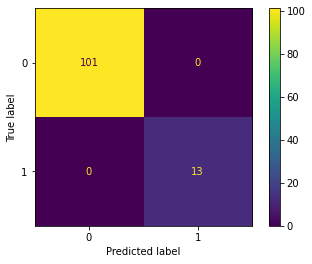

In [638]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)